In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec.splicing_spectrum import *
import os
from astropy.time import Time
from astropy import constants
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
import joblib
import collections
plt.style.use('lijiaostyle')

In [3]:
splicingorderdict = {}

In [4]:
filelist = ['/home/lcq/media/backup/240cm/yf01_reduced/20210105/raw/ljg2m401-yf01-20210105-0049-x00_1ds.fits',
           '/home/lcq/media/backup/240cm/yf01_reduced/20210104/raw/ljg2m401-yf01-20210104-0180-e00_1ds.fits']

In [5]:
filename = filelist[1]
hdu = fits.open(filename)
data = hdu[0].data
header = hdu[0].header
hdu.close()
print(f'data.shape = {data.shape}')

data.shape = (6, 3150)


spec.orders = [12, 11, 10, 9, 8, 7]


(0.0, 2000.0)

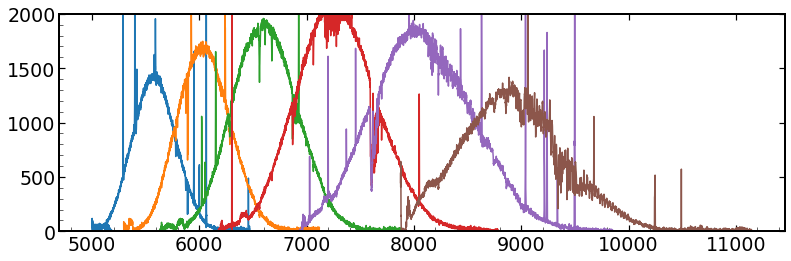

In [6]:
spec = load_multispec(filename)
print(f'spec.orders = {spec.orders}')
splicingorderdict[os.path.basename(filename)] = [12, 11, 10, 9, 8]

fig, ax = plt.subplots(1,1, figsize=(13,4))
for _order in  [12, 11, 10, 9, 8, 7]:
    plt.plot(spec[_order].wv,  spec[_order].flux)
plt.ylim(0,2000)

# splicing spectrum

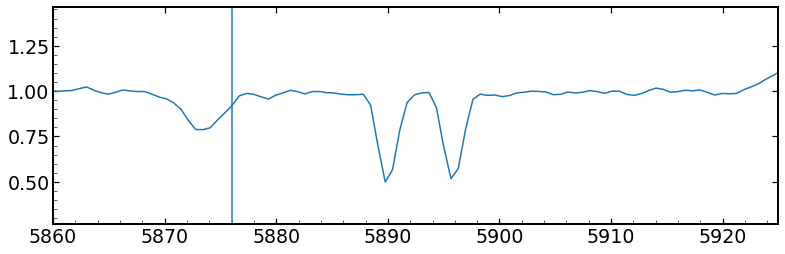

In [18]:
filename = filelist[1]
orders = splicingorderdict[os.path.basename(filename)]
logwave, flux, fluxerr = splicing_irafspectrum(filename, R=3000, N=3, lam_start=5000, lam_end=8000, pix=[590, 2200], funcnorm= None, orders=orders, sigma =3, itera=2,\
                       percentile_up=99.9, percentile_low=0.0,window_length=9, \
                       polyorder=2, show=False)

#---------------------------------------------------
fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(10**logwave, flux)
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.axvline(x=5876)
plt.axvline(x=5800)
plt.xlim(5860, 5925)
#-----------------------------------------------------

#-----------------------write log10wave and flux into a fits-----------------------
fout = os.path.join(os.path.dirname(filename), os.path.basename(filename)[:-5] +'_splicing.fits')
pyrafspc1d2fits(filename, logwave, flux, fluxerr, dire=None, fout=fout)

# measure rv
- load rvm model

(6500.0, 6700.0)

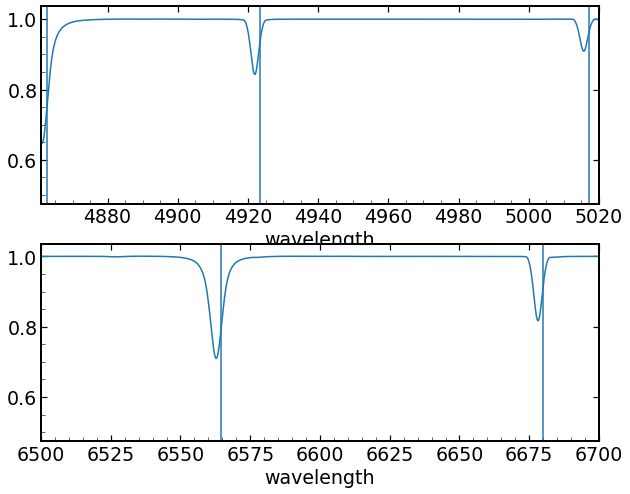

In [36]:
#rvm = joblib.load('/media/share/lijiao/TLUSTY_grid/tlusty_for_bfosc_rv_tyc3340.dump')
#from laspec.ccf import RVM
#_ind = (rvm.pmod[:,0] >= 27000) & (rvm.pmod[:,0] <= 31000)
#pmod_rv = rvm.pmod[_ind]
#wavemod_rv = rvm.wave_mod
#fluxmod_rv = rvm.flux_mod[_ind]
#rvm = RVM(pmod_rv, wavemod_rv, fluxmod_rv, npix_lv=5)

### check rvm model wave is in vacuum or air
haVac = 6564.66464
haAir = 6562.85175
heIAir = 6678.151
heIVac = 6679.995
fig, axs = plt.subplots(2,1,figsize=[10,8])
plt.sca(axs[0])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=4862.6) #vacum
plt.axvline(x=4923.3)#vacuum
plt.axvline(x=5017.07)#vacuum
plt.xlabel('wavelength')
plt.xlim(4861, 5020)

plt.sca(axs[1])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=haVac)
plt.axvline(x=heIVac)
plt.xlabel('wavelength')
plt.xlim(6500, 6700)

rvm.pmod = [[3.00e+04 3.75e+00 1.00e+00 1.00e+01]]


(5200.0, 6900.0)

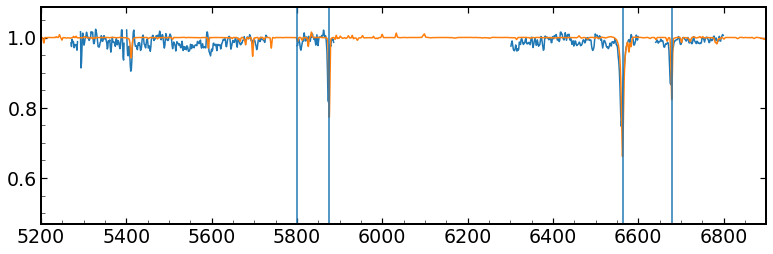

In [37]:
_ind = (rvm.pmod[:, 0] == 30000) & (rvm.pmod[:, 2] == 1) & (rvm.pmod[:, 1] == 3.75)
print(f'rvm.pmod = {rvm.pmod[_ind]}')


fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(10**logwave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[_ind][0])
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.axvline(x=5876)
plt.axvline(x=5800)
plt.xlim(5200, 6900)

- select wavelength area for measuring radial velocity

ljg2m401-yf01-20210104-0180-e00_1ds_splicing.fits


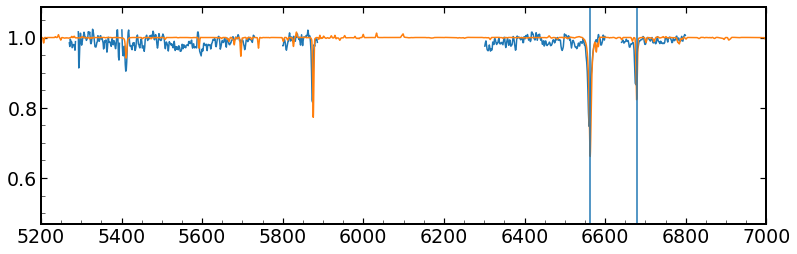

In [38]:
hdul = fits.open(fout)
wave = 10**hdul[1].data['loglambda']
_flux = hdul[1].data['flux'].copy()
hdul.close()


def getrvind(wave):
    ind = ~( (flux > 1.05) |
        (wave < 5270) |
        ((wave >5730) & (wave<5799)) |
        ((wave >5887) & (wave < 6300))|
        ((wave > 6800) & (wave < 7000)) |
        ((wave > 6600) & (wave < 6640))|
        (wave > 7150) |
        np.isnan(flux)
       ) 
    return ind

ind = getrvind(wave)
flux[~ind] = np.nan

fig, ax = plt.subplots(1,1, figsize=[13,4])
plt.plot(wave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[_ind][0])
#plt.xlim(6100, 6800)
plt.axvline(x=6563)
plt.axvline(x=6678)
plt.xlim(5200, 7000)
print(os.path.basename(filename))

In [39]:
dire = '/home/lcq/media/backup/240cm/yf01_reduced/'
fitslist = ['20210105/raw/ljg2m401-yf01-20210105-0049-x00_1ds_splicing.fits',
             '20210104/raw/ljg2m401-yf01-20210104-0180-e00_1ds_splicing.fits']

for filename in fitslist:
    filename = os.path.join(dire, filename) 
    hdul = fits.open(filename)
    wave = 10**hdul[1].data['loglambda']
    wave_obs, flux_obs = wave[ind],  hdul[1].data['flux'][ind]
    print(1/np.std(flux_obs))
    flux_err = np.random.normal(loc=0, scale=np.std(flux_obs), size=np.sum(ind))
    rvr = rvm.measure(wave_obs, flux_obs, flux_err=flux_err, nmc=100, rv_grid=np.arange(-1000, 1000, 5),
                        )
    
    
    rv = rvr['rv_opt']
    err = np.sqrt(np.sum(np.diff(rvr['rv_pct'])**2)/2)
    hdul[0].header['rv'] = (rv, '(km/s)')
    baryrv = rv + hdul[0].header['BARYCORR']*(1 + rv/constants.c.to('km/s').value)
    hdul[0].header['baryrv'] = (baryrv, 'baryrv =rv+BARYCORR(1+rv/c) (km/s)')
    hdul[0].header['rv_err'] = (err, 'radial velocity error(km/s)' )
    hdul.writeto(filename, overwrite=True)
    print(os.path.basename(filename))
    per1, tc1 = (3.3900552015211796, 2457000+1821.4245165431814)
    phase = np.mod((hdul[0].header['bjd'] - tc1)/per1, 1)
    if phase > 0.5: phase -=1
    print(f'phase = {phase}; rv = {baryrv} \pm {err}')

30.414785887907765
ljg2m401-yf01-20210105-0049-x00_1ds_splicing.fits
phase = -0.42828239237573484; rv = 3.7182689155273394 \pm 6.322649740704199
39.75967768106686
ljg2m401-yf01-20210104-0180-e00_1ds_splicing.fits
phase = 0.3161429758877148; rv = -126.78678236088724 \pm 6.509169095711969


In [45]:
rvs = []
baryrvs =[]
rverrs =[]
bjds = []
for filename in fitslist:
    filename = os.path.join(dire, filename) 
    hdul = fits.open(filename)
    bjds.append(hdul[0].header['BJD'])
    rvs.append(hdul[0].header['rv'])
    baryrvs.append(hdul[0].header['baryrv'])
    rverrs.append(hdul[0].header['rv_err'])

In [48]:
baryrvlc = lk.LightCurve(time=bjds, flux=baryrvs, flux_err= rverrs)
rvlc = lk.LightCurve(time=bjds, flux=rvs, flux_err= rverrs)

baryrvdict = collections.OrderedDict(
             baryrvlc = baryrvlc,
             description = 'produced by lcq:/home/lcq/Documents/pyrafspec/pyfile/yfoscE9G10/TYC3340.ipynb')
joblib.dump(baryrvdict, '/home/lcq/media/share/lijiao/OANDBH/dump/radial_velocity/TYC3340_yfosc_rv.dump')

['/home/lcq/media/share/lijiao/OANDBH/dump/radial_velocity/TYC3340_yfosc_rv.dump']